In [ ]:
!pip install squarify

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import squarify 
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from keras.layers import Activation, Dense
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [2]:
df=pd.read_csv('D:\\Datasets\\amazon_alexa.tsv', sep='\t', encoding='cp1252') #decoding the data to codepage 1252

In [3]:
#Checking the shape of the dataframe
df.shape

(3150, 5)

# Data Cleaning

In [4]:
#Checking the top5 rows of the dataframe
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [5]:
#Calculating the missing values for each column in the dataframe
df.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    0
feedback            0
dtype: int64

In [6]:
#Checking the reviews column to see if there are any blank reviews.
#These will not be considered as null values as it contains a 'space'
df[df['verified_reviews'] == ' ']

,rating,date,variation,verified_reviews,feedback
85,5,30-Jul-18,Heather Gray Fabric,,1
183,3,29-Jul-18,Heather Gray Fabric,,1
219,5,29-Jul-18,Sandstone Fabric,,1
374,1,26-Jul-18,Black,,0
406,1,16-Jul-18,White,,0
...,...,...,...,...,...
3114,3,30-Jul-18,Black Dot,,1
3120,5,30-Jul-18,Black Dot,,1
3123,4,30-Jul-18,Black Dot,,1
3126,5,30-Jul-18,Black Dot,,1


In [7]:
#Dropping the rows with character length less than 1 for verified_reviews column
df = df.drop(df[df['verified_reviews'].map(len) <= 1].index)

In [8]:
#Checking the shape of the dataframe again
df.shape

(3071, 5)

In [9]:
df

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1
...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,"Perfect for kids, adults and everyone in betwe...",1
3146,5,30-Jul-18,Black Dot,"Listening to music, searching locations, check...",1
3147,5,30-Jul-18,Black Dot,"I do love these things, i have them running my...",1
3148,5,30-Jul-18,White Dot,Only complaint I have is that the sound qualit...,1


# Visualizations

In [10]:
ratings=df.groupby(['rating']).size()
ratings

rating
1     146
2      92
3     140
4     447
5    2246
dtype: int64

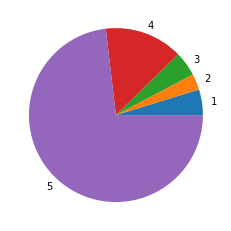

In [11]:
r = ratings.values.tolist() #Converting the series to list
labels = df['rating'].unique() #Getting the unique labels
labels = sorted(labels) #sorting the labels in ascending order
#color = ['red','green','blue','grey','orange'] 
plt.pie(r,labels=labels) #Plotting the pie chart
#squarify.plot(sizes=r,label = labels,color=color,alpha=0.7)
plt.show()

<AxesSubplot:>

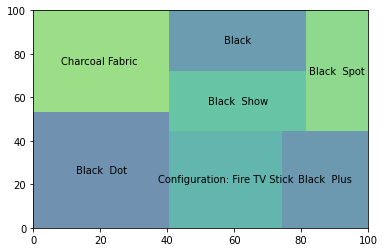

In [12]:
# Plotting a tree map of top 7 variations by number of records
variations=df.groupby(['variation']).size().to_frame(name='record_count').reset_index() # Creating a dataframe variations containing variation and number of records for respective variation as 'record_count'
variations = variations.sort_values(by=['record_count'],ascending=False) # Sorting in descending order  by record count
variations = variations[0:7] # Filtering top 7 rows
squarify.plot(sizes=variations['record_count'],label = variations['variation'],alpha=0.7)

In [13]:
#Changing to lower case
df['verified_reviews'] = df['verified_reviews'].str.lower()

In [14]:
#Checking for HTML tags
df[df['verified_reviews'].str.contains('<.*?>')==True]

,rating,date,variation,verified_reviews,feedback


In [15]:
#Removing and Checking for digits
df['verified_reviews'] = [re.sub("\S*\d\S*", "", e).strip() for e in df['verified_reviews']]
df[df['verified_reviews'].str.contains('\d')==True]

,rating,date,variation,verified_reviews,feedback


In [16]:
# Checking for URLs
df[df['verified_reviews'].str.contains('https')==True]

,rating,date,variation,verified_reviews,feedback


In [17]:
#Decontracting
df['verified_reviews'] = [re.sub(r"won\'t", "will not", e) for e in df['verified_reviews']]
df['verified_reviews'] = [re.sub(r"can\'t", "can not", e) for e in df['verified_reviews']]
df['verified_reviews'] = [re.sub(r"n\'t", " not", e) for e in df['verified_reviews']]
df['verified_reviews'] = [re.sub(r"\'re", " are", e) for e in df['verified_reviews']]
df['verified_reviews'] = [re.sub(r"\'s", " is", e) for e in df['verified_reviews']]
df['verified_reviews'] = [re.sub(r"\'d", " would", e) for e in df['verified_reviews']]
df['verified_reviews'] = [re.sub(r"\'ll", " will", e) for e in df['verified_reviews']]
df['verified_reviews'] = [re.sub(r"\'t", " not", e) for e in df['verified_reviews']]
df['verified_reviews'] = [re.sub(r"\'ve", " have", e) for e in df['verified_reviews']]
df['verified_reviews'] = [re.sub(r"\'m", " am", e) for e in df['verified_reviews']]

In [18]:
#Stop words
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Devendra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
stop = stopwords.words('english')

In [20]:
df['verified_reviews'] = df['verified_reviews'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [21]:
df['verified_reviews']

0                                              love echo!
1                                               loved it!
2       sometimes playing game, answer question correc...
3       lot fun thing. yr old learns dinosaurs, contro...
4                                                   music
                              ...                        
3145              perfect kids, adults everyone between!!
3146    listening music, searching locations, checking...
3147    love things, running entire home, tv, lights, ...
3148    complaint sound quality great. mostly use comm...
3149                                                 good
Name: verified_reviews, Length: 3071, dtype: object

In [22]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Devendra\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [23]:
#Lemmatization
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

df['verified_reviews'] = df.verified_reviews.apply(lemmatize_text)

In [24]:
df

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,"[love, echo!]",1
1,5,31-Jul-18,Charcoal Fabric,"[loved, it!]",1
2,4,31-Jul-18,Walnut Finish,"[sometimes, playing, game,, answer, question, ...",1
3,5,31-Jul-18,Charcoal Fabric,"[lot, fun, thing., yr, old, learns, dinosaurs,...",1
4,5,31-Jul-18,Charcoal Fabric,[music],1
...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,"[perfect, kids,, adult, everyone, between!!]",1
3146,5,30-Jul-18,Black Dot,"[listening, music,, searching, locations,, che...",1
3147,5,30-Jul-18,Black Dot,"[love, things,, running, entire, home,, tv,, l...",1
3148,5,30-Jul-18,White Dot,"[complaint, sound, quality, great., mostly, us...",1


# Building model

In [33]:
#Spliiting into train and test
train_df, test_df = train_test_split(df, test_size = 0.2, random_state = 42)
print("Training data size : ", train_df.shape)
print("Test data size : ", test_df.shape)

Training data size :  (2456, 5)
Test data size :  (615, 5)


In [36]:
top_words = 6000
tokenizer = Tokenizer(num_words=top_words)
tokenizer.fit_on_texts(train_df['verified_reviews'])
list_tokenized_train = tokenizer.texts_to_sequences(train_df['verified_reviews'])

In [39]:
max_review_length = 200
X_train = pad_sequences(list_tokenized_train, maxlen=max_review_length)
y_train = train_df['feedback']

In [48]:
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 32)           192032    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 245,333
Trainable params: 245,333
Non-trainable params: 0
_________________________________________________________________


In [50]:
model.fit(X_train,y_train, epochs=4, batch_size=64, validation_split=0.2)

Epoch 1/4
31/31 [==============================] - 5s 149ms/step - loss: 0.3947 - accuracy: 0.9022 - val_loss: 0.2730 - val_accuracy: 0.9207
Epoch 2/4
31/31 [==============================] - 4s 115ms/step - loss: 0.2683 - accuracy: 0.9185 - val_loss: 0.2625 - val_accuracy: 0.9207
Epoch 3/4
31/31 [==============================] - 4s 115ms/step - loss: 0.2188 - accuracy: 0.9211 - val_loss: 0.2344 - val_accuracy: 0.9207
Epoch 4/4
31/31 [==============================] - 4s 117ms/step - loss: 0.1462 - accuracy: 0.9547 - val_loss: 0.2200 - val_accuracy: 0.9268


# Applying model on testing set and evaluation

In [62]:
list_tokenized_test = tokenizer.texts_to_sequences(test_df['verified_reviews'])
X_test = pad_sequences(list_tokenized_test, maxlen=max_review_length)
y_test = test_df['feedback']
prediction = model.predict(X_test)
y_pred = (prediction > 0.5)
print("Accuracy of the model : ", accuracy_score(y_pred, y_test))
print('F1-score: ', f1_score(y_pred, y_test))
print('Confusion matrix:')
confusion_matrix(y_test,y_pred)

Accuracy of the model :  0.9398373983739837
F1-score:  0.9688814129520605
Confusion matrix:


array([[  2,  37],
       [  0, 576]], dtype=int64)